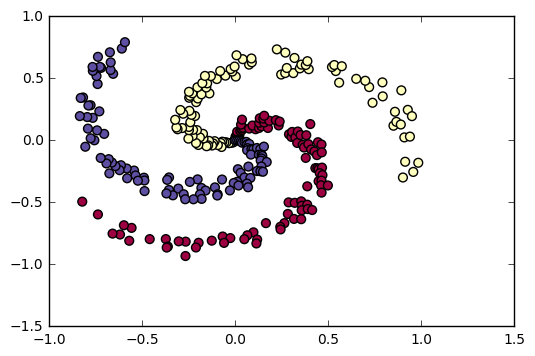

In [1]:
import matplotlib.pyplot as plt
import numpy as np

N = 100 # number of points per class
D = 2 # dimensionality
K = 3 # number of classes
X = np.zeros((N*K,D)) # data matrix (each row = single example)
y = np.zeros(N*K, dtype='uint8') # class labels
for j in xrange(K):
    ix = range(N*j,N*(j+1))
    r = np.linspace(0.0,1,N) # radius
    t = np.linspace(j*4,(j+1)*4,N) + np.random.randn(N)*0.2 # theta
    X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
    y[ix] = j
# lets visualize the data:
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.show()

In [2]:
from numpy import exp, array, random, dot

class NeuronLayer():
    def __init__(self, inputs, neurons, method=None):
        self.W = 0.01 * np.random.randn(inputs, neurons)
        self.b = np.zeros((1,neurons))
        if method != None:
            self.method = method.lower()
        else:
            self.method = None

    # The Sigmoid function, which describes an S shaped curve.
    # We pass the weighted sum of the inputs through this function to
    # normalise them between 0 and 1.
    def sigmoid(self, x):
        return 1. / (1. + exp(-x))

    # The derivative of the Sigmoid function.
    # This is the gradient of the Sigmoid curve.
    # It indicates how confident we are about the existing weight.
    def dsigmoid(self, x):
        return x * (1. - x)
    
    def calculate(self, x):
        score = np.dot(x, self.W) + self.b
        if self.method == "relu":
            return np.maximum(0, score)
        elif self.method == "sigmoid":
            return self.__sigmoid(score)
        else:
            return score

class NeuralNetwork():
    def __init__(self, layers):
        self.layers = layers

    # We train the neural network through a process of trial and error.
    # Adjusting the synaptic weights each time.
    def train(self, training_set_inputs, training_set_outputs, number_of_training_iterations):
        # some hyperparameters
        step_size = 1e-0
        reg = 1e-3 # regularization strength
        num_of_examples = len(training_set_outputs)
        for iteration in xrange(number_of_training_iterations):
            # Pass the training set through our neural network
            layer_outputs = self.calculate_values(training_set_inputs)
             
            first_layer = True
            layer_idx = len(self.layers) - 1
            
            W_adjustments = []
            b_adjustments = []
            step_sizes = []
            reversed_res = layer_outputs[::-1] 
            reversed_res.append(training_set_inputs)
            result_idx = 1
            arma = -1
            for scores in reversed_res[:-1]:
                
                if first_layer:
                    first_layer = False
                    exp_scores = np.exp(scores)
                    probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)

                    # compute the loss: average cross-entropy loss and regularization
                    corect_logprobs = -np.log(probs[range(num_examples),training_set_outputs])
                    data_loss = np.sum(corect_logprobs) / num_examples
                    reg_loss = sum(map(lambda x: 0.5*reg*np.sum(x.W*x.W), self.layers))
                    loss = data_loss + reg_loss
                    dscores = probs
                    dscores[range(num_examples), training_set_outputs] -= 1
                    dscores /= num_examples
                    if iteration % 1000 == 0:
                        print("iteration %d: loss %f" % (iteration, loss))
                else:
                    step_sizes.append(step_size)
                dW = np.dot(reversed_res[result_idx].T, dscores)
                db = np.sum(dscores, axis=0, keepdims=True)
                dW += reg * self.layers[arma].W
                W_adjustments.append(dW)
                b_adjustments.append(db)
                dscores = np.dot(dscores, self.layers[arma].W.T)
                if not first_layer:
                    dscores[reversed_res[result_idx] <= 0] = 0
                result_idx += 1
                arma -= 1
            for layer, dW, db in zip(self.layers, W_adjustments[::-1], b_adjustments[::-1]):
                layer.W += -step_size* dW
                layer.b += -step_size * db

    # The neural network thinks.
    def calculate_values(self, inputs):
        vals = []
        hidden_layer = inputs
        num_of_layers = len(self.layers)
        for each_layer in self.layers:
            scores = each_layer.calculate(hidden_layer)
            hidden_layer = scores
            vals.append(scores)
        return vals

    def guess(self, inputs):
        return self.calculate_values(inputs)[-1]
            
        

In [3]:
h = 100 # size of hidden layer
num_examples = X.shape[0]
#Seed the random number generator
random.seed(1)

W_1 = 0.01 * np.random.randn(D,h)
b_1 = np.zeros((1,h))
W_2 = 0.01 * np.random.randn(h,K)
b_2 = np.zeros((1,K))

D = 2 # dimensionality
h = 100
# Create layer 1 (100 neurons, each with 2 inputs)
layer1 = NeuronLayer(D, h, method="ReLU")

# Create layer 2 (3 neurons (3 classes in output), each with 100 inputs)
layer2 = NeuronLayer(h, K)


layers = [layer1, layer2]

# Combine the layers to create a neural network
neural_network = NeuralNetwork(layers)

print "Stage 1) Random starting synaptic weights: "
#neural_network.print_weights()

# The training set. We have 7 examples, each consisting of 3 input values
# and 1 output value.
training_set_inputs = X
training_set_outputs = y

# Train the neural network using the training set.
# Do it 60,000 times and make small adjustments each time.
neural_network.train(X, y, 10000)

Stage 1) Random starting synaptic weights: 
iteration 0: loss 1.098676
iteration 1000: loss 0.298805
iteration 2000: loss 0.258952
iteration 3000: loss 0.244713
iteration 4000: loss 0.243017
iteration 5000: loss 0.242537
iteration 6000: loss 0.242339
iteration 7000: loss 0.242461
iteration 8000: loss 0.242156
iteration 9000: loss 0.242266
